### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [44]:
''' Silicon 220 crystal '''
# dafault crystal parameters
d_sp = 1.9201374688016222        # reflecting plane d-spacing [A]
psi0r = -9.7640050694412e-06     # real part of 0th Fourier component of crystal polarizability
psi0i = 1.4938680132506875e-07   # imaginary part of ""
psi_hr = -5.932463856370471e-06  # real part of Hth Fourier component
psi_hi = 1.44406950529943e-07    # imaginary part of ""
psi_hbr = -5.932463856370471e-06 # real part of -Hth Fourier coumponent
psi_hbi = 1.44406950529943e-07   # imaginary part of ""
tc = 0.01                        # crystal thickness
ang_as = np.deg2rad(0)           # asymmetric angle
uc = 1                           # use case: 1 (Bragg reflection); 2 (Bragg transmission)

ang_dif_pl = 0                  # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 1.0e-15    # pulse duration (rms) [t]
z1 = 50.0                  # distance to first OE [m]
sigX = 50e-6/2.36           # w0 (rms) [m]
npoints = 8000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

incident beam too short, changing to finer sampling resolution ...


### Calculate sampling parameters

In [45]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 10    # spatial sampling range (5 sigma)
range_xy = 1e-3
nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
pulseRange = trange/pulse_duration
if pulseRange < 30:
    pulseRange = 30
    trange = pulse_duration * pulseRange

dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))


beam parameters:
    10.0keV, 1.0fs, 21.19um w0, 1.86urad divergence
sampling parameters:
    0.1fs dt, 137.86meV deV, 300 nz, 30 pulseRange
other parameters:
    Bragg angle 18.84deg, stretched pulse length 30.0fs


### Generate incident wavefront

generating incident wavefront
saving incident wavefront
finished in 2.83s
R-space


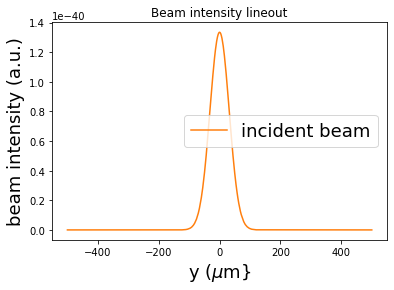

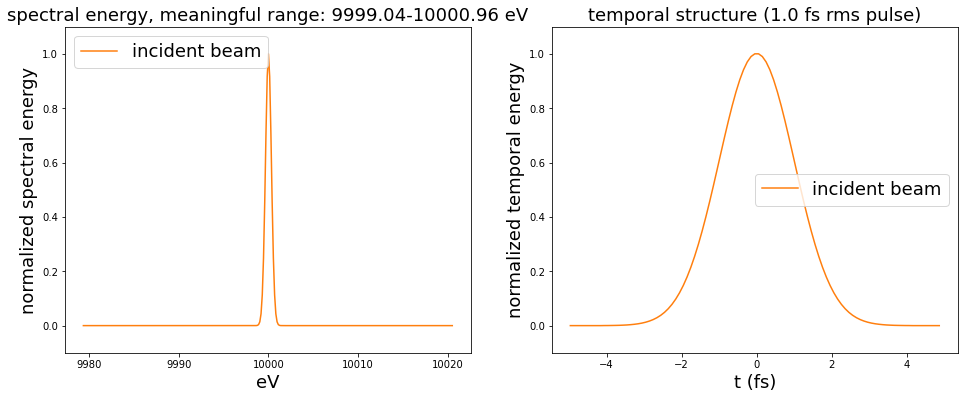

In [46]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Tail_Debug/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}kev_{}fs_beam_dt={}fs_dev={}meV/'.format(
    ekev,round(pulse_duration*1e15,1),round(dt*1e15,2),round(dev*1e3,2))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))

''' plot incident beam structure '''
# spatial profile
if min([npointsx, npointsy])>=4:
    plot_spatial(mwf)
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout(mwf, 'C1',label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')

# spectra
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
aw, evI, intIs = plot_spectra(mwf,'C1', label='incident beam')
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin

# temporal profile
plt.subplot(1,2,2)
aw, tI, intIt = plot_temporal(mwf,'C1', label='incident beam', fov=pulse_duration*10, pulse_duration=pulse_duration)


### Define beamline optics

In [47]:
%autoreload 2
from Optics import *
tstart = time.time()

''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = 0                 # """""""""""""""""""""" second crystal
ang_as2 = 0                 # """""""""""""""""""""" third crystal
ang_as3 = 0                 # """""""""""""""""""""" 4th crystal

OE_Crystal0 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
OE_Crystal1 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
OE_Crystal2 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
OE_Crystal3 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

''' crystal orientation '''
set_crystal_orient(OE_Crystal0, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal1, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal3, ekev*1e3, ang_dif_pl, flip=0)

print('done in {}s'.format(round(time.time()-tstart,2)))


done in 0.0s


### Define beamline

In [48]:
''' propagation distance '''
gapsize = 25.15e-3
z2 = gapsize/np.sin(thetaB0)  # distance between crystal 0 and 1
z3 = 1.0                      # distance between crystal 1 and 2
z4 = z2                       # distance between crystal 2 and 3

dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#              [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCrystal0 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal2 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC2 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal3 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC3 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
# beam after 1st pair of crystals
DriftC0 = SRWLOptD(z2)    # crystal 0 to 1
BL0 = SRWLOptC([OE_Crystal0, DriftC0, OE_Crystal1],
               [ppCrystal0, ppDriftC0, ppCrystal1])

# beam on after 2nd pair of crystals
DriftC1 = SRWLOptD(z3)    # crystal 1 to 2
DriftC2 = SRWLOptD(z4)    # crystal 2 to 3
BL1 = SRWLOptC([DriftC1, OE_Crystal2, DriftC2, OE_Crystal3], [ppDriftC1, ppCrystal2, ppDriftC2, ppCrystal3])

print('done')

done


### Propagation

In [49]:
''' propagation '''
startTime = time.time()

# after 1st pair of crystals
print('\n\n*** through 1st pair of crystals, t = {}s'.format(round(time.time()-startTime,2)))
tstamp = time.time()
fname_cc1 = dirname_prop + 'wavefront_after_cc1.h5'
mwf_cc1 = propagate_wavefront(fname_incident, BL0, fname_cc1)

# after 2nd pair of crystals
print('\n\n*** through 2nd pair of crystals, t = {}s'.format(round(time.time()-tstamp,2)))
tstamp = time.time()
fname_cc2 = dirname_prop + 'wavefront_after_cc2.h5'
mwf_cc2 = propagate_wavefront(fname_cc1, BL1, fname_cc2)

print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))




*** through 1st pair of crystals, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 1.9201374688016222
	nvx = 0
	nvy = 0.9464441720993357
	nvz = -0.32286751013256665
	psi0i = 1.4938680132506875e-07
	psi0r = -9.7640050694412e-06
	psiHbi = 1.44406950529943e-07
	psiHbr = -5.932463856370471e-06
	psiHi = 1.44406950529943e-07
	psiHr = -5.932463856370471e-06
	tc = 0.01
	tvx = 0
	tvy = 0.32286751013256665
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.07789572877640621
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 3.141592653589793
	aux_energy = 10000.0
	dSp = 1.9201374688016222
	nvx = -1.1590598259331182e-16
	nvy = -0.9464441720993357
	nvz = -0.32286751013256665
	psi0i = 1.4938680132506875e-07
	psi0r = -9.7640050694412e-0

### Plot results

R-space
R-space
R-space


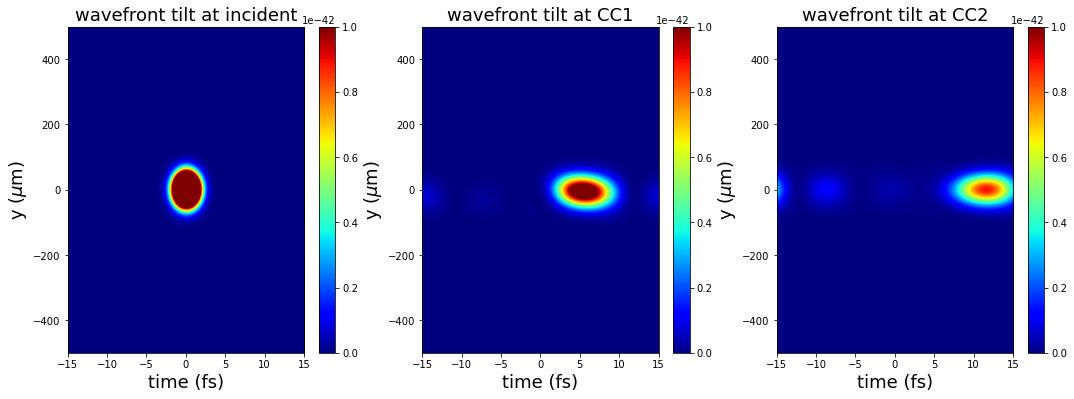

In [53]:
''' wavefront profile everywhere '''
ori = 'V'
if_log = 0
fov_y = 1000    # um
fov_t = trange*1e15    # fs
cmin = 0
cmax = 1e-42
#cmax = np.max(mwf.get_intensity())
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plot_tilt(mwf, 'C1', label='incident',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])
plt.subplot(1,3,2)
plot_tilt(mwf_cc1, 'C2', label='CC1',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])
plt.subplot(1,3,3)
plot_tilt(mwf_cc2, 'C3', label='CC2',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])

plt.savefig(dirname_prop+'wavefront_tilt',transparent=True)

R-space
R-space
R-space


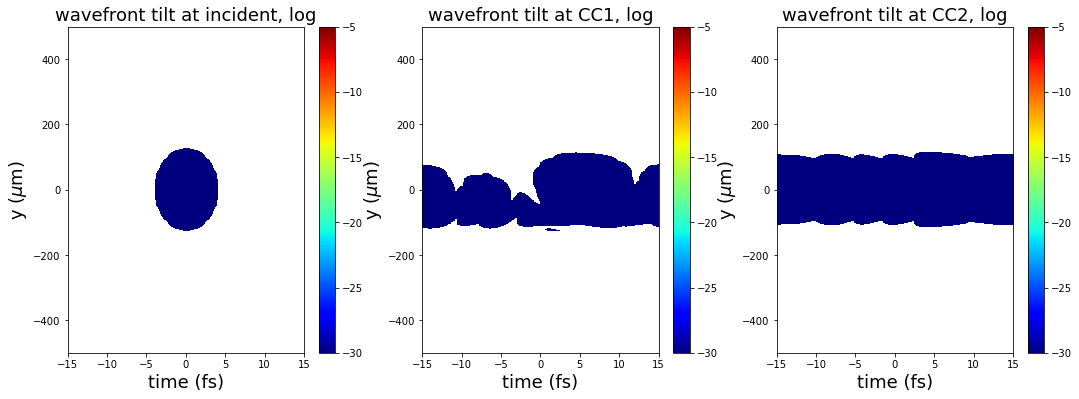

In [51]:
''' wavefront profile everywhere log '''
ori = 'V'
if_log = 1
fov_y = 1000    # um
fov_t = trange*1e15    # fs
cmin = -30; cmax = -5
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plot_tilt(mwf, 'C1', label='incident',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])

plt.subplot(1,3,2)
plot_tilt(mwf_cc1, 'C2', label='CC1',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])

plt.subplot(1,3,3)
plot_tilt(mwf_cc2, 'C3', label='CC2',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim([cmin, cmax])

plt.savefig(dirname_prop+'wavefront_tilt_log.png',transparent=True)

In [52]:
# fresnel distance
(3e8*0.1e-15)**2/wl0

7.2539677268157795e-06